In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
! pip install nbdev

In [ ]:
import os
import math
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from deeplearning_notebooks.utils import *

In [ ]:
print(tf.version.VERSION)

2.2.0


In [ ]:
train_data_fp = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='/content/flowers',untar=True)

228818944/228813984 [==============================] - 2s 0us/step


In [ ]:
#Extract Data
import tarfile
tar_ref = tarfile.open('/content/flowers.tar.gz')
tar_ref.extractall('/content/')

In [ ]:
flowers_dir = Path('/content/flower_photos/')
base_dir = Path('/content/data')
train_dir = base_dir/'train'
test_dir = base_dir/'test'

In [ ]:
base_dir.mkdir()
train_dir.mkdir()
test_dir.mkdir()

In [ ]:
CLASS_NAMES = [folder.name for folder in flowers_dir.glob('*/') if folder.name.find('.') == -1]
print(CLASS_NAMES)

['sunflowers', 'tulips', 'dandelion', 'roses', 'daisy']


In [ ]:
for class_name in CLASS_NAMES:    
    (train_dir / class_name).mkdir()
    (test_dir / class_name).mkdir()

In [ ]:
how_many_in_each_class(flowers_dir,CLASS_NAMES)

class: SUNFLOWERS has: 699 images
class: TULIPS has: 799 images
class: DANDELION has: 898 images
class: ROSES has: 641 images
class: DAISY has: 633 images


In [ ]:
for class_name in CLASS_NAMES:
    if (flowers_dir / class_name).is_dir():
        copy_data(flowers_dir / class_name, train_dir / class_name, copy_rate = 0.9)
        copy_data(flowers_dir / class_name, test_dir / class_name, copy_rate = 0.1)

In [ ]:
how_many_in_each_class(train_dir, CLASS_NAMES)

class: SUNFLOWERS has: 629 images
class: TULIPS has: 719 images
class: DANDELION has: 808 images
class: ROSES has: 576 images
class: DAISY has: 569 images


In [ ]:
how_many_in_each_class(test_dir, CLASS_NAMES)

class: SUNFLOWERS has: 69 images
class: TULIPS has: 79 images
class: DANDELION has: 89 images
class: ROSES has: 64 images
class: DAISY has: 63 images


In [ ]:
num_train = len([image for image in train_dir.glob('*/*')])
num_test = len([image for image in test_dir.glob('*/*')])
print('Number of training images: {}'.format(num_train))
print('Number of testing images: {}'.format(num_test))

Number of training images: 3301
Number of testing images: 364


In [ ]:
channels = 3
img_width = 256
img_height = 256
batch_size = 4
num_batches_train = int(num_train / batch_size)
num_batches_test = int(num_test / batch_size)

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
pre_trained = tf.keras.applications.Xception(include_top=False, 
                                             weights='imagenet', 
                                             input_shape=(img_width,img_height,3))

83689472/83683744 [==============================] - 2s 0us/step


In [ ]:
pre_trained.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
class DataProcessor():
    def __init__(self, img_width, img_height, class_names):
        self.width = img_width
        self.height = img_height
        self.class_names = class_names

    def process_path(self, file_path):
        label = self.get_label(file_path)
        img_file = tf.io.read_file(file_path)
        img = self.decode_img(img_file)
        img = tf.image.resize(img, [self.width, self.height], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return img, label

    def decode_img(self, img):
        img_tensor = tf.image.decode_jpeg(img, channels=3)
        img_tensor = tf.cast(img_tensor, dtype=tf.float32)
        return img_tensor 

    def get_label(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        res = parts[-2] == self.class_names
        return res

In [ ]:
class DataTransformer():
    def __init__(self, device_type: str = 'cpu', device_id: int = 0):
        assert device_type in ['cpu', 'gpu']
        self.device_type = device_type.upper() + ':' + str(device_id)

    def transform(self, img, label):
        with tf.device(self.device_type):
            img = tf.image.random_flip_left_right(img)
            # img = tf.image.random_brightness(img, max_delta=0.2)
            img = tf.image.random_saturation(img, lower=0.0, upper=2.0)
            img = tf.image.random_contrast(img, lower=0.8, upper=1.3)
            img = tf.image.rot90(img,tf.random.uniform(shape=[], minval=0, maxval=3, dtype=tf.int32))
            img = tf.image.transpose(img)
        return img, label

In [ ]:
def input_preprocess_wrapper(img, label):
    return tf.keras.applications.xception.preprocess_input(img), label

In [ ]:
data_processor = DataProcessor(img_width, img_height, CLASS_NAMES)

In [ ]:
data_transformer = DataTransformer(device_type='gpu', device_id=0)

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(train_dir/'*/*'))
test_dataset = tf.data.Dataset.list_files(str(test_dir/'*/*'))

In [ ]:
train_dataset = (train_dataset.map(data_processor.process_path, 
                                   num_parallel_calls=AUTOTUNE)
                                .map(input_preprocess_wrapper)
                                .cache('/content/train')
                                .shuffle(1000)
                                .batch(batch_size)
                                .map(data_transformer.transform)
                                .repeat(1)
                                .prefetch(AUTOTUNE))

In [ ]:
test_dataset = (test_dataset.map(data_processor.process_path, 
                                   num_parallel_calls=AUTOTUNE)
                                .map(input_preprocess_wrapper)
                                .cache('/content/test')
                                .shuffle(1000)
                                .batch(batch_size)
                                .map(data_transformer.transform)
                                .repeat(1)
                                .prefetch(AUTOTUNE))

In [ ]:
top_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(2048, activation=tf.nn.relu),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [ ]:
model = tf.keras.Sequential([
    pre_trained,
    top_model
])

In [ ]:
top_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 2048)              268437504 
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 270,540,805
Trainable params: 270,540,805
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
sequential (Sequential)      (None, 5)                 270540805 
Total params: 291,402,285
Trainable params: 291,347,757
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
freeze_unfreeze_layers(pre_trained, freeze_mode=True)

In [ ]:
list_layers(pre_trained)

name: input_1, trainable: False
name: block1_conv1, trainable: False
name: block1_conv1_bn, trainable: False
name: block1_conv1_act, trainable: False
name: block1_conv2, trainable: False
name: block1_conv2_bn, trainable: False
name: block1_conv2_act, trainable: False
name: block2_sepconv1, trainable: False
name: block2_sepconv1_bn, trainable: False
name: block2_sepconv2_act, trainable: False
name: block2_sepconv2, trainable: False
name: block2_sepconv2_bn, trainable: False
name: conv2d, trainable: False
name: block2_pool, trainable: False
name: batch_normalization, trainable: False
name: add, trainable: False
name: block3_sepconv1_act, trainable: False
name: block3_sepconv1, trainable: False
name: block3_sepconv1_bn, trainable: False
name: block3_sepconv2_act, trainable: False
name: block3_sepconv2, trainable: False
name: block3_sepconv2_bn, trainable: False
name: conv2d_1, trainable: False
name: block3_pool, trainable: False
name: batch_normalization_1, trainable: False
name: add_1, t

In [ ]:
ckpt = tf.train.Checkpoint(weights = model.weights)

In [ ]:
ckpt_dir = './../Experiments/Flowers_Classifier/weights'
ckpt_callback = CheckPointManagerCallback(ckpt, 
                                          ckpt_dir,
                                          after_num_epoch=10,
                                          max_to_keep=1,
                                          checkpoint_name='flowers_classifier_Adadelta_optimizer_no_tune')

In [ ]:
model.compile(optimizer=tf.optimizers.Adadelta(),
              loss = tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
%%time
train_history = model.fit(train_dataset,
          epochs=50,
          validation_data=test_dataset,
          callbacks = [ckpt_callback])

Epoch 1/50
826/826 [==============================] - 50s 61ms/step - loss: 0.7693 - accuracy: 0.7322 - val_loss: 0.5397 - val_accuracy: 0.8132
Epoch 2/50
826/826 [==============================] - 44s 53ms/step - loss: 0.4850 - accuracy: 0.8307 - val_loss: 0.4558 - val_accuracy: 0.8269
Epoch 3/50
826/826 [==============================] - 44s 53ms/step - loss: 0.4221 - accuracy: 0.8458 - val_loss: 0.4033 - val_accuracy: 0.8571
Epoch 4/50
826/826 [==============================] - 44s 53ms/step - loss: 0.3792 - accuracy: 0.8685 - val_loss: 0.3740 - val_accuracy: 0.8654
Epoch 5/50
826/826 [==============================] - 44s 53ms/step - loss: 0.3398 - accuracy: 0.8812 - val_loss: 0.3500 - val_accuracy: 0.8709
Epoch 6/50
826/826 [==============================] - 44s 53ms/step - loss: 0.3116 - accuracy: 0.8982 - val_loss: 0.3227 - val_accuracy: 0.8791
Epoch 7/50
826/826 [==============================] - 44s 53ms/step - loss: 0.2966 - accuracy: 0.9012 - val_loss: 0.2695 - val_accuracy:

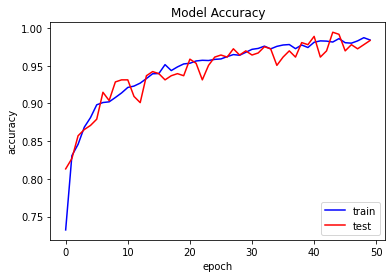

In [ ]:
plt.plot(train_history.history['accuracy'],color='blue')
plt.plot(train_history.history['val_accuracy'],color='red')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='lower right')
plt.show()

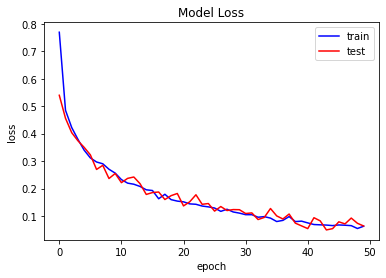

In [ ]:
plt.plot(train_history.history['loss'], color='blue')
plt.plot(train_history.history['val_loss'], color='red')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper right')
plt.show()

In [ ]:
[layer.name for layer in pre_trained.layers[-16:]]

['block13_sepconv1_act',
 'block13_sepconv1',
 'block13_sepconv1_bn',
 'block13_sepconv2_act',
 'block13_sepconv2',
 'block13_sepconv2_bn',
 'conv2d_3',
 'block13_pool',
 'batch_normalization_3',
 'add_11',
 'block14_sepconv1',
 'block14_sepconv1_bn',
 'block14_sepconv1_act',
 'block14_sepconv2',
 'block14_sepconv2_bn',
 'block14_sepconv2_act']

In [ ]:
top_layers = ['block13_sepconv1_act',
                'block13_sepconv1',
                'block13_sepconv2_act',
                'block13_sepconv2',
                'conv2d_3',
                'block13_pool',
                'add_11',
                'block14_sepconv1',
                'block14_sepconv1_act',
                'block14_sepconv2',
                'block14_sepconv2_act']

In [ ]:
freeze_unfreeze_layers(pre_trained,layers=top_layers,freeze_mode=False)
list_layers(pre_trained)

name: input_1, trainable: False
name: block1_conv1, trainable: False
name: block1_conv1_bn, trainable: False
name: block1_conv1_act, trainable: False
name: block1_conv2, trainable: False
name: block1_conv2_bn, trainable: False
name: block1_conv2_act, trainable: False
name: block2_sepconv1, trainable: False
name: block2_sepconv1_bn, trainable: False
name: block2_sepconv2_act, trainable: False
name: block2_sepconv2, trainable: False
name: block2_sepconv2_bn, trainable: False
name: conv2d, trainable: False
name: block2_pool, trainable: False
name: batch_normalization, trainable: False
name: add, trainable: False
name: block3_sepconv1_act, trainable: False
name: block3_sepconv1, trainable: False
name: block3_sepconv1_bn, trainable: False
name: block3_sepconv2_act, trainable: False
name: block3_sepconv2, trainable: False
name: block3_sepconv2_bn, trainable: False
name: conv2d_1, trainable: False
name: block3_pool, trainable: False
name: batch_normalization_1, trainable: False
name: add_1, t

In [ ]:
freeze_unfreeze_layers(top_model)
list_layers(top_model)

name: flatten, trainable: False
name: dense, trainable: False
name: dense_1, trainable: False
name: dense_2, trainable: False


In [ ]:
model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.000005, momentum=0.9),
              loss = tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
%%time
fine_tune_history = model.fit(train_dataset,
                              epochs=25,
                              validation_data=test_dataset,
                              callbacks=[ckpt_callback])

Epoch 1/25
826/826 [==============================] - 40s 49ms/step - loss: 0.0502 - accuracy: 0.9864 - val_loss: 0.0544 - val_accuracy: 0.9890
Epoch 2/25
826/826 [==============================] - 39s 48ms/step - loss: 0.0574 - accuracy: 0.9861 - val_loss: 0.0624 - val_accuracy: 0.9780
Epoch 3/25
826/826 [==============================] - 40s 48ms/step - loss: 0.0444 - accuracy: 0.9915 - val_loss: 0.0510 - val_accuracy: 0.9890
Epoch 4/25
826/826 [==============================] - 40s 48ms/step - loss: 0.0425 - accuracy: 0.9885 - val_loss: 0.0488 - val_accuracy: 0.9863
Epoch 5/25
826/826 [==============================] - 40s 48ms/step - loss: 0.0439 - accuracy: 0.9882 - val_loss: 0.0499 - val_accuracy: 0.9890
Epoch 6/25
826/826 [==============================] - 40s 48ms/step - loss: 0.0386 - accuracy: 0.9903 - val_loss: 0.0388 - val_accuracy: 0.9945
Epoch 7/25
826/826 [==============================] - 40s 48ms/step - loss: 0.0428 - accuracy: 0.9876 - val_loss: 0.0409 - val_accuracy: